<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/kernel_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a neighborhood windows and machine learning to estimate tree canopy cover
## In this notebook we will explore the use of Raster Tools and Scikit learn functions to incorporate texture and intensity into the modeling process. Key objectives:
- Determine and use cell values of a moving window (user defined size) that can be used to optimally transform a given image and its bands into estimates of some known phenomena.
- Create surfaces that estimate a given phenomena within a raster.
### The approach
- Use sampling to select train locations
- Extract and flatten cell values for a defined area around each location
- Train a machine learning model (Gradient Boosted Regression)
- Apply the model back to the input data

John Hogland 12/30/2024

#### Study area for this example includes portions of the Custer Gallatin Nation Forest

Install packages

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac
!pip install owslib


Import libraries

In [1]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import Raster, general
from raster_tools import raster
from owslib.wcs import WebCoverageService


c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Introduction
### Both intensity and texture play import roles as predictor values in regression, classification, and clustering projects that aim to estimating some known phenomena using remotely sensed data. While intensity is well defined for a given image (i.e., the cell value), texture can be somewhat ambiguous to quantify and is often subjectively determined prior to the modeling process.
### In this example we explore using image cell values extracted for a defined neighborhood (window) within the modeling process to produce estimates of percent canopy cover for a portion of the Custer Gallatin National Forest located in southeastern Montana, USA (Figure 1). 

#### Get the boundary data for portions of the Custer Gallatin National Forest and create a interactive location map of the study (Figure 1).

In [2]:
import folium
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore(color='red',style_kwds=dict(fill=False,weight=5))
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_15036\4288319230.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


__Figure 1.__ Interactive location map of the study area.

## Methods
### To estimate percent canopy cover using Landsat 8 imagery we implemented a multistep approach. 
1. Dowload MRLC's 2016 tree canopy cover (TCC) raster surface and part of a Landsat scene for the area around the Custer Gallatin Nation Forest (Figure 1) from MLRC's WCS service and Planetary Computer, respectively. 
2. Create a simple random sample of 150 locations and extract the cell values (and neighboring window cell values) at those location for the TCC and Landsat datasets.
4. Created a Gradient Boosted Regression model (GBRM) using the sample. 
5. Apply our newly developed GBRM back to our predictor variables. 

To perform these steps, we created a series of python functions that utilize Scikit Learn and Raster Tools application programming interface (API). 

### Step 1. Get Tree Canopy Cover and Landsat 8 Imagery
Create download definitions

In [3]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic

# Create definition for WCS download
def get_wcs_data(url,ply,service_name='mrlc_download__nlcd_tcc_conus_2021_v2021-4',out_prefix = 'tcc'):
    '''
    Extracts saves an image from a WCS given url, polygon boundary, and service name. Images are saved in the same location as the notebook.
    url = (string) path to wcs e.g. 'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2021_v2021-4/wcs?'
    ply = (geoseries or geodataframe) of the study area
    service_name = (string) name of the service e.g. mrlc_download__nlcd_tcc_conus_2021_v2021-4
    out_prefix = (string) prefix used to save each image

    returns a Raster object
    '''
    wcs=WebCoverageService(url)
    tcc=wcs.contents[service_name]
    bbox=tuple(ply.total_bounds)
    subsets=[('X',bbox[0],bbox[2]),('Y',bbox[1],bbox[3])]
    rsp=wcs.getCoverage(identifier=[tcc.id],subsets=subsets,format='geotiff')
    outpath='./'+out_prefix+'.tif'
    with open(outpath,'wb') as file:
        file.write(rsp.read())

    return Raster(outpath)


Download the data and create the raster objects

In [4]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

#Load the Landsat raster
ls30s=Raster('ls82016.tif')

#get TCC data
if(not os.path.exists('cf1.tif')): #if the 2016 tree canopy cover file does not exits, download it
    url=r'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2016_v2021-4/wcs?'
    sn='mrlc_download__nlcd_tcc_conus_2016_v2021-4'
    get_wcs_data(url=url,ply=nf1p,service_name=sn,out_prefix='cf1')


#Load the TCC raster
tcc_rs=Raster('cf1.tif')

### Visualize the boundary and  imagery

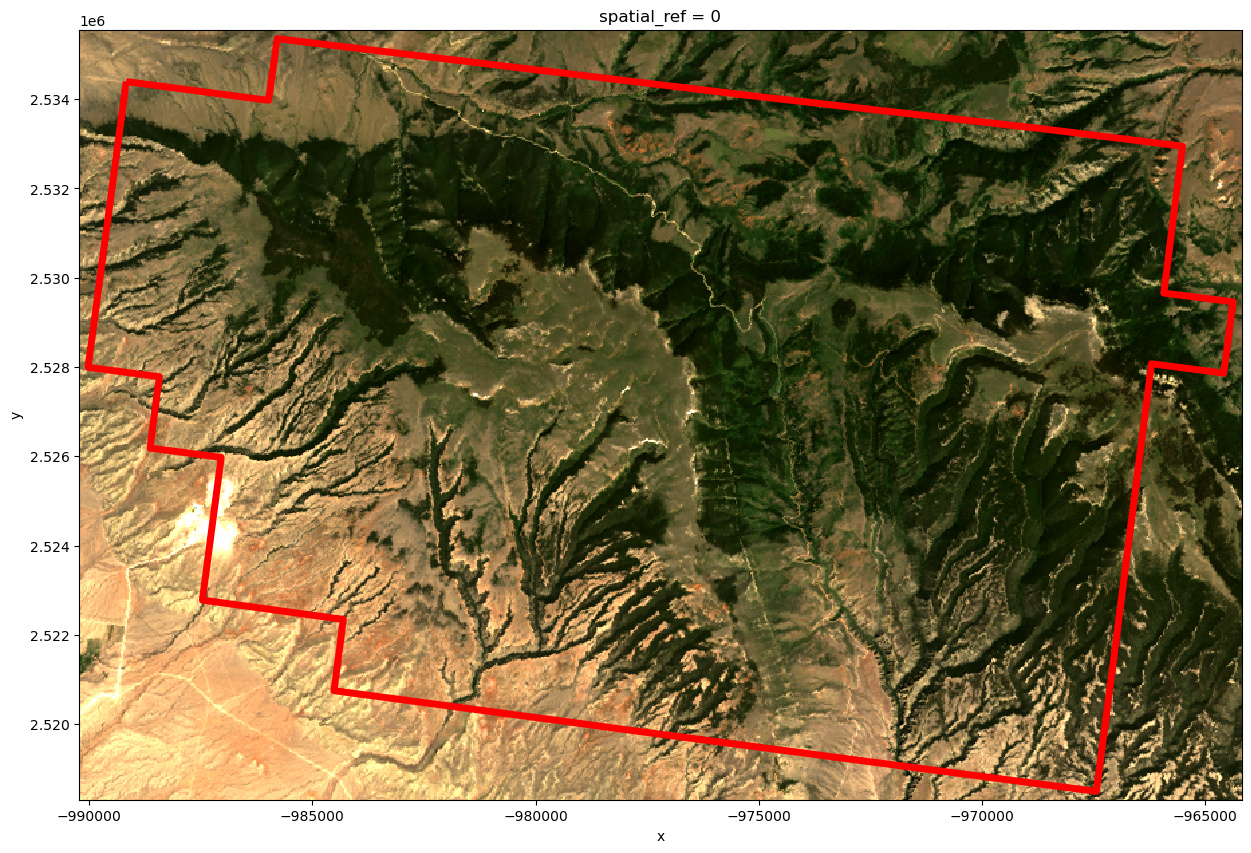

In [5]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,10),linewidth=5)
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)


__Figure 2.__ Overlay of Landsat 8 image subset (RGB bands) and the study area boundary outline in red.

### Step 2. Create Sample
Create definitions to sample the data.

In [6]:
import shapely, xarray as xr, numba as nb

#Create a random sample definition
def get_random_sample(bnd, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    bnd = (GeoDataFrame or GeoSeries) project boundary
    n = number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = bnd.total_bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    ubnd=bnd.unary_union
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = shapely.geometry.Point([x, y])
        if pnt.intersects(ubnd):
            pnts_lst.append(pnt)

    dic = {"geometry": pnts_lst}
    gdf = gpd.GeoDataFrame(dic, crs=bnd.crs)

    return gdf

@nb.jit(nopython=True, nogil=True)
def _expand_pnts_for_kernel(isys,isxs,wsize):
    '''
    Extracts values for kernel cells. Cells indices falling on the boundary of the image are moved in one index value.
    isys=array of row index locations
    isxs=array of column index locations
    wsize=width of the kernel
    
    returns two new lists of index values kernel cell locations that can be used to extract coordinate from an xarray data array
    '''
    hw=int(wsize/2)
    isys2=np.zeros(isys.shape[0]*wsize*wsize,dtype='int32')
    isxs2=np.zeros(isxs.shape[0]*wsize*wsize,dtype='int32')
    cnt=0
    for r in range(isys.shape[0]):
        rvl=isys[r]
        cvl=isxs[r]
        rvlm=rvl-hw
        for r2 in range(wsize):
            nr=rvlm+r2
            cvlm=cvl-hw
            for c2 in range(wsize):
                nc=cvlm+c2
                isys2[cnt]=nr
                isxs2[cnt]=nc
                cnt+=1

    return isys2,isxs2

def create_sample(bndr,r_rs,pred_rs,n,wsize=1):
    '''
    Creates a simple random sample of locations given a boundary and n and extracts response and predictor variables values for those location and the cell surrounding those locations.
    bndr = GeoDataFrame or GeoSeries of the boundary
    r_rs = response Raster object to be sampled
    pred_rs= predictor Raster object to be sampled
    n = (integer) sample size
    wsize=(int) width of a square kernel in cells

    returns a GeoDataFrame of response and predictor cell values
    '''
    pnts=get_random_sample(bndr,n=n)
    xs=pnts.geometry.x
    ys=pnts.geometry.y
    rws=xs.shape[0]

    #get response values
    isys,isxs=r_rs.index(xs,ys)
    rsel=r_rs.xdata.isel(x=xr.DataArray(isxs,dims='loc'),y=xr.DataArray(isys,dims='loc'))
    rvls=pd.DataFrame(rsel.values.reshape((rws,1)),columns=['response'])

    #get predictor values
    isys,isxs=pred_rs.index(xs,ys)



    if(wsize>1):
        isys,isxs=_expand_pnts_for_kernel(isys.values,isxs.values,wsize)

    sel=pred_rs.xdata.isel(x=xr.DataArray(isxs,dims='loc'),y=xr.DataArray(isys,dims='loc'))
    pvls=sel.values.reshape((pred_rs.shape[0],rws,wsize*wsize))
    clms=sel.shape[0]*wsize*wsize
    pvls=pd.DataFrame(np.moveaxis(pvls,1,0).reshape(rws,clms),columns=['p' + str(sub) for sub in np.arange(clms)])

    df=pd.concat([pnts,pvls,rvls],axis=1)
    vls=df.dropna()#(df[df!=r_rs.null_value]).dropna()

    return vls



Get the sample

In [7]:
# Create a sample of 150 random locations with a 5 by 5 window size.
ksize=5
pnts=create_sample(nf1p,r_rs=tcc_rs,pred_rs=ls30s,n=150,wsize=ksize)

In [8]:
pnts

geometry        p0        p1        p2        p3  \
0    POINT (-986166.108 2527470.338)  0.063450  0.082095  0.053990  0.093975   
1    POINT (-984065.002 2528385.452)  0.053028  0.060727  0.058308  0.064688   
2    POINT (-969300.409 2527201.012)  0.025418  0.024785  0.022888  0.023795   
3    POINT (-976857.495 2530936.061)  0.086935  0.092133  0.085257  0.074835   
4    POINT (-988120.107 2529566.470)  0.130578  0.129780  0.146637  0.125078   
..                               ...       ...       ...       ...       ...   
145  POINT (-987135.494 2533989.478)  0.093370  0.113198  0.114133  0.124830   
146  POINT (-982969.617 2524117.829)  0.151010  0.153568  0.152523  0.151120   
147  POINT (-973533.838 2519628.863)  0.158490  0.151285  0.141550  0.141880   
148  POINT (-986955.415 2523596.465)  0.218110  0.226470  0.229110  0.202050   
149  POINT (-988394.552 2532251.866)  0.046318  0.038810  0.060150  0.121750   

           p4        p5        p6        p7        p8  ...      p166  \
0    0.127607  0.057538  0.035428  0.030835  0.039827  ...  0.160608   
1    0.053990  0.050223  0.055750  0.066227  0.061443  ...  0.119275   
2    0.023328  0.021457  0.023383  0.025032  0.024840  ...  0.067273   
3    0.056905  0.085395  0.089108  0.085313  0.060095  ...  0.135610   
4    0.110833  0.118340  0.129780  0.132915  0.143998  ...  0.222675   
..        ...       ...       ...       ...       ...  ...       ...   
145  0.116607  0.079537  0.098842  0.116030  0.120650  ...  0.168583   
146  0.148040  0.149250  0.149168  0.149938  0.154502  ...  0.264860   
147  0.141605  0.148810  0.151203  0.144410  0.143228  ...  0.239972   
148  0.216020  0.223555  0.224077  0.213050  0.199273  ...  0.289583   
149  0.106488  0.042440  0.038562  0.050415  0.052698  ...  0.087485   

         p167      p168      p169      p170      p171      p172      p173  \
0    0.086715  0.075770  0.142650  0.213078  0.200867  0.170810  0.140505   
1    0.137288  0.098815  0.103407  0.121833  0.126975  0.153073  0.118752   
2    0.110283  0.100768  0.108413  0.071370  0.115233  0.136132  0.143282   
3    0.136848  0.121997  0.129092  0.122988  0.142155  0.136270  0.114765   
4    0.242503  0.234445  0.269728  0.212363  0.228148  0.227488  0.231063   
..        ...       ...       ...       ...       ...       ...       ...   
145  0.154228  0.168363  0.186128  0.186045  0.174247  0.176227  0.177822   
146  0.264970  0.262275  0.253530  0.249488  0.235270  0.236947  0.249708   
147  0.258893  0.271213  0.278665  0.272450  0.249323  0.251165  0.257352   
148  0.267225  0.252623  0.273468  0.317605  0.274265  0.258975  0.256088   
149  0.092215  0.085037  0.085973  0.092792  0.086083  0.095432  0.092737   

         p174  response  
0    0.142650        61  
1    0.118230         0  
2    0.087072        64  
3    0.116717         0  
4    0.282653         0  
..        ...       ...  
145  0.187887         0  
146  0.244455         0  
147  0.253145         0  
148  0.260020         0  
149  0.089410        44  

[150 rows x 177 columns]

### Step 3: Create the Gradient Boosted Regression Model

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(subsample=0.66,random_state=0,learning_rate=0.1)
tdf_train = pnts.sample(110)
tdf_val=pnts.iloc[~pnts.index.isin(tdf_train.index)].copy()
pred_clm=tdf_train.columns[1:-1]
X=tdf_train[pred_clm].values
y=tdf_train['response'].values
reg.fit(X,y)

pred=reg.predict(tdf_val[pred_clm].values)
tdf_val['pred']=pred
tdf_train['pred']=reg.predict(tdf_train[pred_clm].values)

#### Look at model fit using training and validation dataset

Training Data
Response std = 26.247053927375458
RMSE = 0.4652062143612092
train r2 = 0.9996934955829169


<Axes: title={'center': 'Train Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

Response std = 26.24519492040889
RMSE = 9.484369980966038
val r2 = 0.8882778945196215


<Axes: title={'center': 'Validation Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

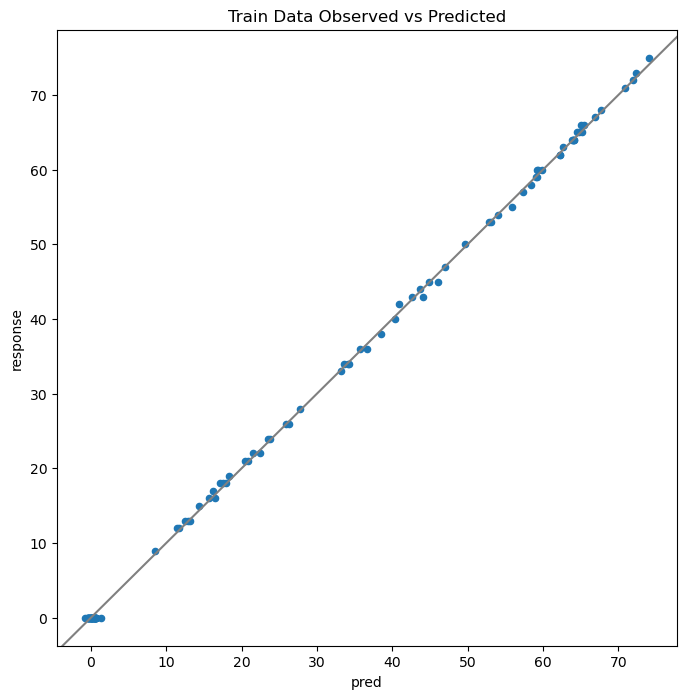

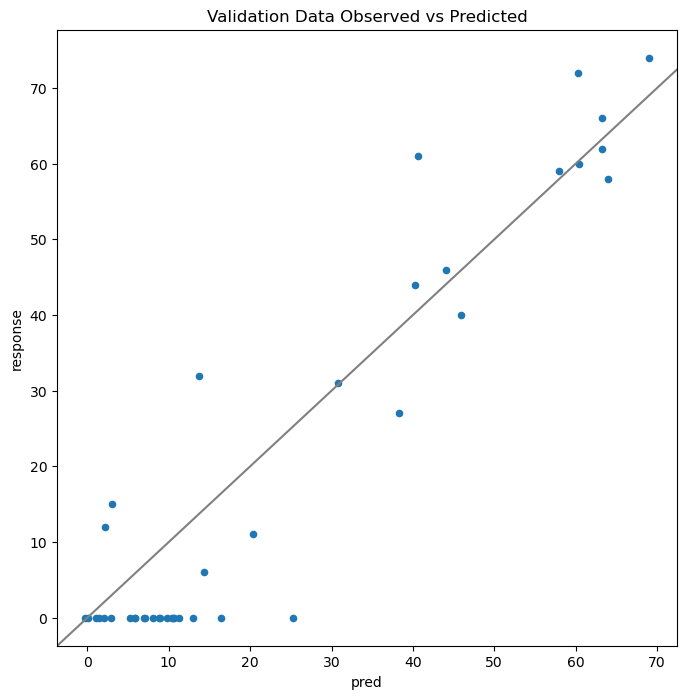

In [10]:
#training dataset
print('Training Data')
print('Response std =',tdf_train['response'].std())
evdf=tdf_train[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('train r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Train Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

#validation dataset
print('Response std =',tdf_val['response'].std())
evdf=tdf_val[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('val r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Validation Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

#### Look at variable importance fo the top ten features. 
In this case which cells are contributing most to the model

37     0.155168
136    0.132008
141    0.107757
163    0.094264
36     0.064394
133    0.049669
38     0.047511
32     0.044356
42     0.028301
138    0.022968
dtype: float64


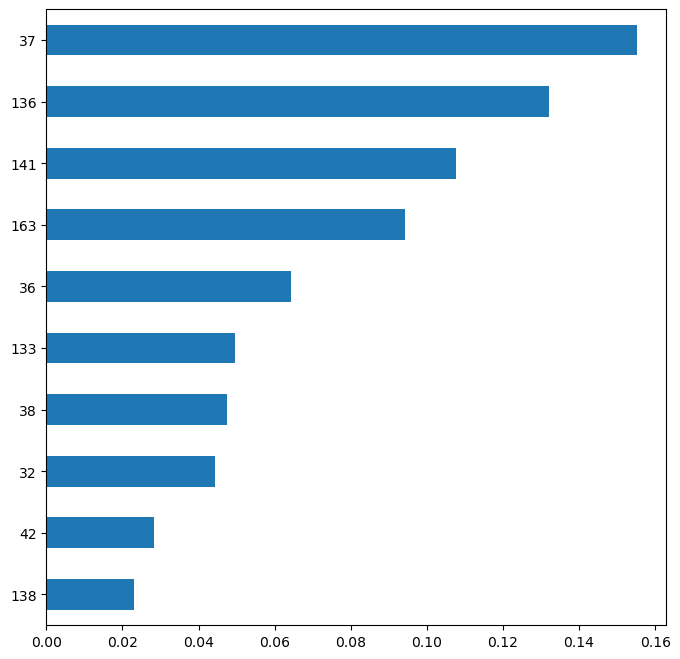

In [11]:
imp=pd.Series(reg.feature_importances_)
imp2=imp.sort_values(ascending=False)
print(imp2[:10])
imp2.iloc[:10].plot(kind='barh',figsize=(8,8)).invert_yaxis()

### Step 4: Apply to Landsat predictor surfaces
#### Create definitions

In [12]:
@nb.jit(nopython=True, nogil=True)
def _conv_flatten(x, size):
    '''
    reshapes the array for model implementation

    x=(numpy array) of data
    size= (int) width of the kernel

    returns a numpy array of correct shape for models
    '''
    bnd,rws,clms=x.shape
    
    hs=int(size/2)
    outarr=np.zeros(((rws-(2*hs))*(clms-(2*hs)),bnd*size*size))
    cnt=0
    for ri in range(hs,rws-hs):
        sr=ri-hs
        for ci in range(hs,clms-hs):
            sc=ci-hs
            vls=x[:,sr:sr+size,sc:sc+size].flatten()
            vls=np.nan_to_num(vls,0) #set null values to zero
            outarr[cnt]=vls
            cnt+=1

    return outarr

def _conv_model(X,mdl,wsize,outbnds=1):
    ''' 
    Applies a model developed from convolution kernel cell values to a specified array. Used with dask's map_overlap function.
    
    X = (array) numpy array
    mdl = (object) model object with a predict function
    wsize = (int) kernel width
    outbnds = (int) number of output bands
    '''
    bnd,rws,clms=X.shape
    hw=int(wsize/2)*2
    nx=_conv_flatten(X,wsize)
    outvl=mdl.predict(nx)

    return outvl.reshape((outbnds,rws-hw,clms-hw))

def conv_mdl(rs,mdl,ksize,outbands=1):
    ''' 
    Creates a raster surface for a given model derived from the values within a sample of locations and neighboring cell values. Neighboring cell values are determined based on the size of a convolution kernel.
    rs = (Raster) input dataset used to train the model
    mdl =  a model with a predict function
    ksize = the width of the convolution kernel
    outbands = the number of output bands from the model

    returns a raster dataset of predicted values
    '''
    hw=int(ksize/2)
    rs2=rs.chunk((rs.nbands,*rs.data.chunks[1:]))
    nch=rs2.data.chunks
    och=list(nch)
    och[0]=(outbands,)
    och[1]=tuple(och[1])
    och[2]=tuple(och[2])
    #use map overlap function to retrieve kernel cell values
    darr = rs2.data.map_overlap(
        _conv_model,
        depth={0: 0, 1: hw, 2: hw},
        chunks=och,
        trim=False,
        boundary=0,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        mdl=mdl,
        wsize=ksize,
        outbnds=outbands
    )
    #convert dask array back to a raster
    out_rs=raster.data_to_raster(darr,mask=rs.mask[0:outbands],x=rs2.x,y=rs2.y,affine=rs2.affine,crs=rs2.crs).chunk((1,*darr.chunks[1:]))
    return out_rs

#### Apply the model and visualize the results

In [13]:
tcc2_rs=conv_mdl(ls30s,reg,ksize,outbands=1)
display(tcc2_rs.xdata)
tcc2_rs.explore(band=1,cmap='PRGn') #purple to green -> low to high TCC

<xarray.DataArray 'raster' (band: 1, y: 575, x: 868)> Size: 4MB
dask.array<_conv_model, shape=(1, 575, 868), dtype=float64, chunksize=(1, 575, 868), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 2.536e+06 2.536e+06 ... 2.518e+06 2.518e+06
  * x            (x) float64 7kB -9.902e+05 -9.902e+05 ... -9.642e+05 -9.642e+05
    spatial_ref  int32 4B 0
  * band         (band) int32 4B 1
Attributes:
    _FillValue:  -999999.0

#### Compare against actual TCC values

RMSE = 9.321721900274197


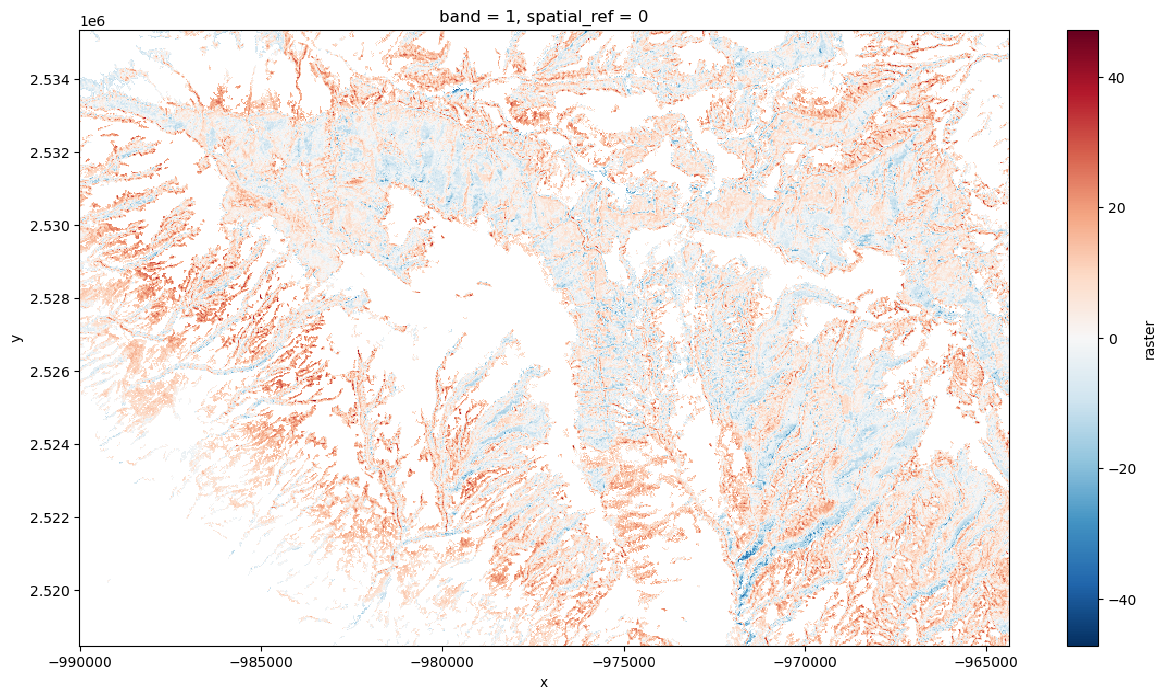

In [14]:
dif=(tcc_rs-tcc2_rs.reproject(tcc_rs.geobox))
print('RMSE =',np.sqrt(np.mean(dif*dif)).compute())

dif.plot(figsize=(15,8))

## Discussion
### In this notebook we have demonstrated how to use simple random sampling, neighborhood windows, and Gradient Boosted Regression Trees to estimate tree canopy cover (TCC) from multi-band Landsat 8 data. Notably, of our example emphasize both intensity and textural aspects within the data that are uniquely optimized to estimate TCC, given the training data. Intuitively, some band and cell combinations have more importance than others (feature importance graphic). However, allowing the modeling technique to "weight" each band\cell combination gives the optimization methodology the flexibility to learn patterns of intensity and texture that strongly relate to TCC. 

### Some additional ways to improve the model may be to adjust modeling parameters, include additional data (elevation data), modify the window size, transform the data to independent components before using as predictor surfaces, and\or improve the spread and balance of the sample. Alternatively, a different modeling approach could potentially reduce modeling error. However, this notebook demonstrates how can use Raster Tools and neighborhood windows in a manner that reduces estimation error in a efficient, practical way.  
               